In [1]:
from symusic import Score
import pandas as pd
import numpy as np
import json
import os
import sys
import math
import torch
import random
from matplotlib import pyplot as plt
from utils import track_to_list

from data.Dataset import MidiDataset
from torch.utils.data import DataLoader

In [51]:
dataset = MidiDataset(json_dir='./data/data.json', max_seq_len=512)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [4]:
full_dataset = MidiDataset('./data.json', 512)
train_dataset = MidiDataset('./data.json', 512, 'train', .7)
test_dataset = MidiDataset('./data.json', 512, 'test', .7)

In [55]:
iter(dataloader)

TypeError: '_SingleProcessDataLoaderIter' object is not subscriptable

### Notes:
Only work on single time_signature, key_signarture, or tempo tracks for now.

## Dataset

In [7]:
def get_song_details(dir):
    """
    Input midi directory.
    Output song details as a dict().
    """
    try:
        midi = Score(dir)
    except:
        print(f'ERROR with: {dir}')
        return None

    n_tracks = sum(1 if not t.is_drum else 0 for t in midi.tracks) # Count non-drum tracks.
    if n_tracks <= 1:                   # Discard songs with only one track.
        print(f'SINGLE TRACK: {dir}')
        return None

    time_signatures = midi.time_signatures
    if len(time_signatures) > 1:        # Discard songs with multiple time signatures.
        print(f'MULTI SIGNATURE: {dir}')
        return None

    tempos = midi.tempos
    if len(tempos) > 1:                 # Discard songs with multiple tempos.
        print(f'MULTI TEMPO: {dir}')
        return None

    keys = midi.key_signatures
    if len(keys) > 1:                   # Discard songs with multiple keys.
        print(f'MULTI KEY: {dir}')
        return None

    song = {
        'Midi_Directory': dir,
        'Artist': dir.split('/')[-2],
        'Song': dir.split('/')[-1][:-4]
    }
    return song

# def is_synchronous(midi):
    

In [8]:
# data = []
# data_folder = './archive'

# for root, dirs, files in os.walk(data_folder):
#     for file in files:
#         if not file.endswith('.mid'):
#             continue
#         midi_directory = os.path.join(root, file)
#         song_details = get_song_details(midi_directory)
#         if song_details:
#             data.append(song_details)

# print(f"Number of songs: {len(data)}")
# json_file_path = "data.json"
# with open(json_file_path, "w") as json_file:
#     json.dump(data, json_file, indent=4)

In [8]:
midi = Score('./archive/VOF_de_Kunst/Een_kopje_koffie.mid')

name: #A.Piano 
frame_pianoroll uint8 (1, 128, 167733)


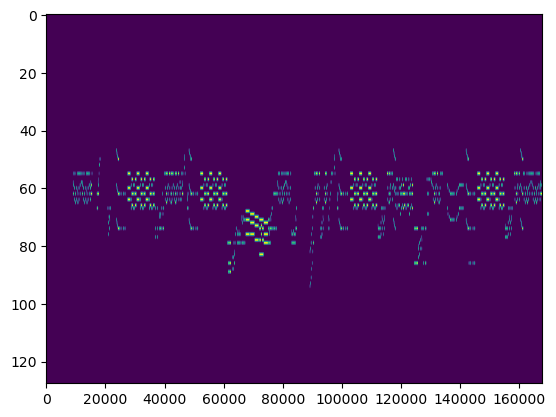

In [9]:
track = midi.tracks[14]
print(f"name: {track.name}")


frame_pianoroll = track.pianoroll(['frame'])
print("frame_pianoroll", frame_pianoroll.dtype, frame_pianoroll.shape)
plt.imshow(frame_pianoroll[0], aspect='auto')

In [10]:
def get_clipped_tracks(midi, n_bars=16, zero_index=True, include_empty_start=False, visualize=False, debug=False):
    '''
    Returns smaller clips in the size "n_bars".
    '''
    time_sig = (midi.time_signatures[0].numerator, midi.time_signatures[0].denominator)
    bar_length = int(midi.tpq * time_sig[0] * (4 / time_sig[1]))
    first_note_time = min(t.notes[0].time for t in midi.tracks if t.notes)

    note_32nd = midi.tpq // 8

    if include_empty_start:
        loop_start = midi.start()
    else:
        for s in range(midi.start(), midi.end(), bar_length):
            if first_note_time <= s:
                loop_start = s
                break

    clipped_tracks = dict()

    for track in midi.tracks:

        if track.is_drum:   # Skip if drum track.
            continue

        if debug or visualize:
            print(f"Processing track \"{track.name}\"")

        clipped_track = []

        for i in range(loop_start, midi.end(), n_bars * bar_length):
            start_tick = i - note_32nd
            end_tick = min(start_tick + (n_bars * bar_length), midi.end())
            
            if end_tick - start_tick < bar_length:  # Skip if less than one bar.
                continue
            
            clipped_part = track.clip(start_tick, end_tick, clip_end=True)
            if zero_index:
                notes_list = track_to_list(clipped_part, start_tick)
            else:
                notes_list = track_to_list(clipped_part)
            clipped_track.append(notes_list)

            if debug:
                print("---")
                print(f"Clip from: {i}")
                print(f"Bars in clip: {(end_tick - start_tick) / bar_length}")
                print(f"Number of notes in clip: {len(clipped_part.notes)}")

            if visualize:
                frame_pianoroll = clipped_part.pianoroll(['frame'])
                plt.imshow(frame_pianoroll[0,:,start_tick:], aspect='auto')
                plt.title(f"Clip from: {i}")
                plt.show()
        
        clipped_tracks[track.name] = clipped_track

    return clipped_tracks

In [13]:
clipped_midi = get_clipped_tracks(midi, n_bars=4)

In [17]:
clipped_midi.keys()

dict_keys(['#A.Piano ', 'Fing.Bass', 'Brass Sec', 'Vocal-Lin', '#Rtr.Orga', '#Mtd.Gtr.', '#Chrs.Gtr', 'Dist.Gtr.', 'Gt.Hrmncs'])

In [18]:
clipped_midi

{'#A.Piano ': [[[6180, 102, 58, 108],
   [6180, 230, 62, 83],
   [6248, 148, 59, 83],
   [6384, 178, 55, 74],
   [6574, 168, 60, 101],
   [6574, 154, 64, 101],
   [6766, 156, 55, 70],
   [6952, 200, 62, 101],
   [6954, 182, 65, 92],
   [7336, 198, 60, 92],
   [7338, 184, 64, 94],
   [7534, 158, 55, 73],
   [7714, 90, 61, 101],
   [7714, 236, 65, 83],
   [7768, 154, 62, 74],
   [7914, 176, 55, 74],
   [8106, 196, 60, 110],
   [8108, 176, 64, 95],
   [8302, 182, 55, 66],
   [8490, 178, 59, 101],
   [8490, 178, 62, 101],
   [8684, 164, 55, 66],
   [8872, 196, 58, 92],
   [9064, 170, 55, 70],
   [9252, 102, 58, 98],
   [9252, 230, 62, 83],
   [9320, 148, 59, 83],
   [9456, 178, 55, 74],
   [9646, 168, 60, 101],
   [9646, 154, 64, 104],
   [9838, 156, 55, 70],
   [10024, 200, 62, 101],
   [10026, 182, 65, 92],
   [10408, 198, 60, 92],
   [10410, 184, 64, 94],
   [10606, 158, 55, 73],
   [10786, 90, 61, 101],
   [10786, 236, 65, 83],
   [10840, 154, 62, 74],
   [10986, 176, 55, 74],
   [1117

In [27]:
dic = {
    'a': 1,
    'b': 2
}

list(dic.items())

[('a', 1), ('b', 2)]

In [29]:
from datetime import datetime
print(f"log {datetime.now()}.txt")

log 2024-07-03 23:52:59.589551.txt


In [34]:
# random.seed = 42
with open('./data.json', 'r') as data_json:
    data = json.load(data_json)
random.Random(42).shuffle(data)

In [35]:
data

[{'Midi_Directory': './archive/Alain_Souchon/Lamour_en_fuite.mid',
  'Artist': 'Alain_Souchon',
  'Song': 'Lamour_en_fuite'},
 {'Midi_Directory': './archive/ABC/Look_of_Love,_Part_1.mid',
  'Artist': 'ABC',
  'Song': 'Look_of_Love,_Part_1'},
 {'Midi_Directory': './archive/Vincent_Gene/Be_Bob_A-Lula.1.mid',
  'Artist': 'Vincent_Gene',
  'Song': 'Be_Bob_A-Lula.1'},
 {'Midi_Directory': './archive/BOWIE_DAVID/Modern_Love.2.mid',
  'Artist': 'BOWIE_DAVID',
  'Song': 'Modern_Love.2'},
 {'Midi_Directory': './archive/Tears_for_Fears/Everybody_Wants_To_Rule_The_World.mid',
  'Artist': 'Tears_for_Fears',
  'Song': 'Everybody_Wants_To_Rule_The_World'},
 {'Midi_Directory': './archive/The_Beatles/Like_Dreamers_Do.mid',
  'Artist': 'The_Beatles',
  'Song': 'Like_Dreamers_Do'},
 {'Midi_Directory': './archive/883/Sei_un_mito.mid',
  'Artist': '883',
  'Song': 'Sei_un_mito'},
 {'Midi_Directory': './archive/Thomas_Dolby/She_Blinded_Me_With_Science.1.mid',
  'Artist': 'Thomas_Dolby',
  'Song': 'She_Blind

In [45]:
from datetime import datetime, date
print(date.today())
print(datetime.now().date())

2024-07-04
2024-07-04


In [48]:
datetime.now()

datetime.datetime(2024, 7, 4, 22, 32, 29, 419683)